In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf hw2
git clone https://github.com/mit-6864/hw2.git

Cloning into 'hw2'...


In [ ]:
import sys
sys.path.append("/content/hw2")

import csv
import itertools as it
import numpy as np
import sklearn.decomposition
from tqdm import tqdm

import lab_util

# Introduction

In this notebook, you will find code scaffolding for the implementation portion of Homework 1. Make sure to read the text between cells for certain implementation details. Please submit the notebook with all code cells running.


## Dataset

We're going to be working with a dataset of product reviews. The following cell loads the dataset and splits it into training, validation, and test sets.

In [ ]:
data = []
n_positive = 0
n_disp = 0
with open("/content/hw2/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue
      n_positive += 1
    if len(data) == 4000:
      break

    data.append((review, label))

    if n_disp > 5:
      continue
    n_disp += 1
    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")
np.random.seed(0)
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews, train_labels = reviews[:3000], labels[:3000]
val_reviews, val_labels = reviews[3000:3500], labels[3000:3500]
test_reviews, test_labels = reviews[3500:], labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

# Preliminaries: Word-document representations

We start by constructing the bag-of-words matrix (look at `/content/hw2/lab_util.py` in the file browser on the left if you want to see how this works).

In [ ]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
bow_matrix = vectorizer.transform(train_reviews)
print(f"BoW matrix is {bow_matrix.shape[0]} x {bow_matrix.shape[1]}")

BoW matrix is 3000 x 2006


In class, we've seen that we can get more informative representations by using representations other than raw counts. Implement the TF-IDF transform below.

Note: In lecture, we multiplied the raw term frequencies by idfs to get the TF-IDF matrix (tfidf=tf*idf). Feel free to experiment with other transformations, such as log(1+tf) for the measure of term frequency.

In [ ]:
class TfidfFeaturizer:
    def fit(self, matrix):
        # `matrix` is a `|V| x |D|` matrix of raw counts, where `|V|` is the
        # vocabulary size and `|D|` is the number of documents in the corpus.
        # This function should create the inverse document frequency (idf) matrix
        # for the given term-document matrix.

        self.idf = np.log(matrix.shape[1] / np.count_nonzero(matrix, axis = 1)).reshape(-1,1) 
        #matrix.shape[1] gives # of documents
        #np.count_nonzero(matrix, axis = 1) gives number of non-zero elements in each row of the matrix -> if non-zero, then the document must contain word w_i
        #reshape into a |V| x 1 array

        return self.idf

    def transform_tfidf(self, matrix):
        # `matrix` is a `|V| x |D|` matrix of raw counts, where `|V|` is the
        # vocabulary size and `|D|` is the number of documents in the corpus. This
        # function should (nondestructively) return a version of `matrix` with the
        # TF-IDF transform applied.

        return np.multiply(matrix, self.idf)
        #multiply each value in a row of matrix by the value in the corresponding row in idf -> element-wise multiplication

td_matrix = bow_matrix.T
featurizer = TfidfFeaturizer()
featurizer.fit(td_matrix)
tfidf_matrix = featurizer.transform_tfidf(td_matrix)
print(f"TF-IDF matrix is {tfidf_matrix.shape[0]} x {tfidf_matrix.shape[1]}")

TF-IDF matrix is 2006 x 3000


#### Sanity check 1
The following cell should print `True` if your `transform_tfidf` function is implemented properly. (*Hint: in our implementation, we use the natural logarithm (base $e$) when computing inverse document frequency.*)

In [ ]:
DEBUG_sc1_matrix = np.array([[3,1,0,3,0],
                             [0,2,0,0,1],
                             [7,8,2,0,1],
                             [1,9,8,1,0]])
DEBUG_gt = np.array([[1.53247687, 0.51082562, 0.        , 1.53247687, 0.        ],
                     [0.        , 1.83258146, 0.        , 0.        , 0.91629073],
                     [1.56200486, 1.78514841, 0.4462871 , 0.        , 0.22314355],
                     [0.22314355, 2.00829196, 1.78514841, 0.22314355, 0.        ]])
debug = TfidfFeaturizer()
debug.fit(DEBUG_sc1_matrix)
print(np.allclose(debug.transform_tfidf(DEBUG_sc1_matrix), DEBUG_gt))

True


#### Linear models on BoW and TFIDF features

Now we have two feature representations, BoW and TF-IDF. Let's first see how effective these features are for the sentiment classification task.

Below, implement two logistic regression models to classify the reviews, using BoW and TF-IDF respectively. You should feel free to use the `scikit-learn` library, which has the `sklearn.linear_model.LogisticRegression` available for you. Report the training and test accuracy of these two models.

Note: For the TF-IDF classifier, we only fit the IDF matrix to the training data. (Think about why you might not want a separate IDF for the test set!)


In [68]:
from sklearn.linear_model import LogisticRegression

def train_and_eval(train_X, train_y, test_X, test_y):
    # Create and train a model that takes as input a feature
    # representation of the training data and outputs a sentiment label.
    # Make sure to report the training and test accuracy of your model.
    # Hint: changing max_iter might be helpful

    classifier = LogisticRegression(max_iter = 1000)
    classifier.fit(train_X, train_y)
    print('Training accuracy: ', classifier.score(train_X, train_y))
    print('Testing accuracy: ', classifier.score(test_X, test_y))
    return classifier

bow_matrix_test = vectorizer.transform(test_reviews)
print('Logistic regression with bag of word features')
bow_model = train_and_eval(bow_matrix, train_labels, bow_matrix_test, test_labels)

td_bow_matrix_test = bow_matrix_test.T
tfidf_matrix_test = featurizer.transform_tfidf(td_bow_matrix_test)

print('Logistic regression with tf-idf features')
tfidf_model = train_and_eval(tfidf_matrix.T, train_labels, tfidf_matrix_test.T, test_labels)
#transpose matrix to obtain shape 3000 x 2006, "undo" initial transpose where each row represented a word instead of a document

Logistic regression with bag of word features
Training accuracy:  0.9853333333333333
Testing accuracy:  0.818
Logistic regression with tf-idf features
Training accuracy:  1.0
Testing accuracy:  0.818


Let's look at what the model learns about sentiment. For both models, display the top 5 most positive and negative weights, as well as their corresponding words.

Hint: look at `/content/hw2/lab_util.py` for how to convert between token indices and words.

In [ ]:
bow_coef = np.squeeze(bow_model.coef_)
tfidf_coef = np.squeeze(tfidf_model.coef_)
#returns 1 x 2006 matrix of coefficients, each value corresponds to the coef of a word

#indices of top 5 most positive coef
bow_pos = np.argsort(bow_coef)[::-1][:5]
#indices of top 5 most negative coef
bow_neg = np.argsort(bow_coef)[:5]

#indices of top 5 most positive coef
tfidf_pos = np.argsort(tfidf_coef)[::-1][:5]
#indices of top 5 most negative coef
tfidf_neg = np.argsort(tfidf_coef)[:5]

#return words corresponding to coefficients
tokenizer = lab_util.Tokenizer()
tokenizer.fit(train_reviews)
bow_pos_words = [tokenizer.token_to_word[token] for token in bow_pos]
bow_neg_words = [tokenizer.token_to_word[token] for token in bow_neg]
tfidf_pos_words = [tokenizer.token_to_word[token] for token in tfidf_pos]
tfidf_neg_words = [tokenizer.token_to_word[token] for token in tfidf_neg]


print('BoW Top 5 Positive Coefficients: ', bow_coef[bow_pos])
print('BoW Top 5 Positive Words: ', bow_pos_words)
print('BoW Top 5 Negative Coefficients: ', bow_coef[bow_neg])
print('BoW Top 5 Negative Words: ', bow_neg_words)
print('TF-IDF Top 5 Positive Coefficients: ', tfidf_coef[tfidf_pos])
print('TF-IDF Top 5 Positive Words: ', tfidf_pos_words)
print('TF-IDF Top 5 Negative Coefficients: ', tfidf_coef[tfidf_neg])
print('TF-IDF Top 5 Negative Words: ', tfidf_neg_words)

BoW Top 5 Positive Coefficients:  [1.72739723 1.67083365 1.4088365  1.38438414 1.3212818 ]
BoW Top 5 Positive Words:  ['delicious', 'great', 'best', 'thanks', 'long']
BoW Top 5 Negative Coefficients:  [-1.61921888 -1.57610189 -1.49583019 -1.49166462 -1.43355986]
BoW Top 5 Negative Words:  ['stick', 'disappointed', 'unfortunately', 'gf', 'yuck']
TF-IDF Top 5 Positive Coefficients:  [1.55104441 1.03294607 0.99075237 0.83433262 0.76264566]
TF-IDF Top 5 Positive Words:  ['great', 'best', 'tassimo', 'delicious', 'long']
TF-IDF Top 5 Negative Coefficients:  [-1.41169962 -0.8874562  -0.887032   -0.84948908 -0.83957873]
TF-IDF Top 5 Negative Words:  ['not', 'unfortunately', 'disappointed', 'disappointing', 'gf']


# LSA: Word representations via matrix factorization

In class, we've seen that the above approaches can lead to high dimensional representations. To alleviate this, we can use latent semantic analysis (LSA).

First, implement the function `learn_reps_lsa` that computes word representations via latent semantic analysis. The `sklearn.decomposition` or `np.linalg` packages may be useful.

In [ ]:
def learn_reps_lsa(matrix, rep_size):
    # `matrix` is a `|V| x |D|` matrix, where `|V|` is the number of words in the
    # vocabulary and |D| is the number of training reviews. This function should
    # return a `|V| x rep_size` matrix with each row corresponding to a word
    # representation. The `sklearn.decomposition` package may be useful.

    #n_components = rep_size to set dimensionality of output data to rep_size
    svd = sklearn.decomposition.TruncatedSVD(n_components = rep_size)
    #perform dimensionality reduction, matrix_tranform is U*Sigma
    matrix_transform = svd.fit_transform(matrix)
    #divide by sigma to get U
    return matrix_transform/svd.singular_values_

#### Sanity check 2
The following cell contains a simple sanity check for your `learn_reps_lsa` implementation: it should print `True` if your `learn_reps_lsa` function is implemented equivalently to one of our solutions.

In [ ]:
DEBUG_sc2_matrix = np.array([[1,0,0,2,1,3,5],
                             [2,0,0,0,0,4,0],
                             [0,3,4,1,8,6,6],
                             [1,4,5,0,0,0,0]])

DEBUG_reps = learn_reps_lsa(DEBUG_sc2_matrix, 3)
DEBUG_gt1 = np.array([[ -4.92017554,  -2.85465774,   1.18575453],
                      [ -2.14977584,  -1.19987977,   3.37221899],
                      [-12.62664695,   0.10890093,  -1.32131745],
                      [ -2.69216011,   5.66453534,   1.33728063]])
DEBUG_gt2 = np.array([[-0.35188159, -0.44213061,  0.29358929],
                      [-0.15374788, -0.18583789,  0.83495136],
                      [-0.90303377,  0.01686662, -0.32715426],
                      [-0.19253817,  0.87732566,  0.3311067 ]])

print(np.allclose(np.abs(DEBUG_reps), np.abs(DEBUG_gt1)) or np.allclose(np.abs(DEBUG_reps), np.abs(DEBUG_gt2)))

[[ 0.35188159 -0.44213061  0.29358929]
 [ 0.15374788 -0.18583789  0.83495136]
 [ 0.90303377  0.01686662 -0.32715426]
 [ 0.19253817  0.87732566  0.3311067 ]]
True


Let's look at some representations:

In [ ]:
# LSA reps for term-document matrix
# Feel free to change the rep size!
reps = learn_reps_lsa(td_matrix, 500)
words = ["good", "bad", "cookie", "jelly", "dog", "the", "3"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

[[ 6.89031937e-01  6.72372892e-01 -1.78411037e-01 ...  1.28130508e-04
   1.60684095e-03  7.02211718e-04]
 [ 2.31553598e-02 -5.20963554e-02  1.21153239e-02 ...  3.05514831e-03
  -9.62010244e-03  4.90180454e-04]
 [ 3.83301968e-02 -4.29225155e-02  1.93856196e-02 ... -1.81005338e-03
  -3.80044991e-03  5.13465873e-04]
 ...
 [ 3.17231578e-04 -6.50245704e-04  1.52675912e-03 ...  1.48220545e-03
  -1.62735306e-02 -9.36258303e-03]
 [ 4.42263586e-04 -2.14287700e-04 -4.98282343e-04 ... -1.32911630e-03
  -1.80351283e-02  1.83700880e-03]
 [ 2.76302849e-03  1.39797955e-02 -5.86256685e-03 ... -1.45004611e-02
  -1.69507825e-02  3.71098967e-03]]
good 47
  gerber 1.882
  crazy 1.888
  luck 1.895
  suspect 1.901
  flaxseed 1.914
bad 201
  disgusting 1.617
  horrible 1.772
  dont 1.786
  positive 1.788
  within 1.795
cookie 504
  nana's 0.990
  bars 1.399
  odd 1.401
  cookies 1.435
  impossible 1.477
jelly 351
  twist 1.207
  cardboard 1.213
  advertised 1.352
  peanuts 1.392
  plastic 1.405
dog 925
  hap

How do the given similar words change if we apply LSA to the TF-IDF matrix instead?

In [ ]:
# Feel free to change the rep size!
reps_tfidf = learn_reps_lsa(tfidf_matrix, 500)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

[[ 0.10305843 -0.02823013  0.0005387  ... -0.00931948  0.01296273
   0.00058102]
 [ 0.06121867 -0.00787906  0.13199975 ...  0.01831991  0.00359527
   0.00944958]
 [ 0.07905045 -0.00272372  0.09267989 ...  0.00077055 -0.01610395
  -0.01223471]
 ...
 [ 0.00502214  0.00256818 -0.00766008 ... -0.01461276 -0.00923553
  -0.00845382]
 [ 0.00553081 -0.00273609  0.00441299 ...  0.02542507 -0.00052825
   0.00373317]
 [ 0.02840451 -0.09642188 -0.00128551 ... -0.01221491  0.01642628
  -0.00626993]]
good 47
  crazy 1.718
  gerber 1.727
  homemade 1.779
  beat 1.797
  average 1.807
bad 201
  disgusting 1.662
  awful 1.703
  dont 1.714
  bland 1.718
  gone 1.722
cookie 504
  nana's 1.110
  moist 1.405
  impossible 1.439
  odd 1.440
  needs 1.489
jelly 351
  twist 1.143
  cardboard 1.229
  advertised 1.376
  sold 1.496
  ask 1.523
dog 925
  happier 1.637
  earlier 1.668
  foods 1.678
  standard 1.688
  stays 1.699
the 36
  <unk> 1.484
  and 1.584
  . 1.596
  of 1.605
  is 1.625
3 289
  supermarket 1.6

Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews, or reviews without any additional human annotation, can improve classification.

In [65]:
import sklearn.linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def word_featurizer(xs):
    # normalize
    return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the learned feature representation of each review (e.g. the sum of LSA
    # word representations).

    feats = np.dot(xs, reps_tfidf)

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

def combo_featurizer(xs):
    return np.concatenate((word_featurizer(xs), lsa_featurizer(xs)), axis=1)

def train_model(featurizer, xs, ys):
    xs_featurized = featurizer(xs)
    model = sklearn.linear_model.LogisticRegression(penalty='none', max_iter=1000)
    model.fit(xs_featurized, ys)
    return model

def eval_model(model, featurizer, xs, ys):
    xs_featurized = featurizer(xs)
    pred_ys = model.predict(xs_featurized)
    return np.mean(pred_ys == ys)

def training_experiment(name, featurizer, n_train):
    print(f"{name} features, {n_train} examples")
    train_xs = vectorizer.transform(train_reviews[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_reviews)
    test_ys = test_labels
    model = train_model(featurizer, train_xs, train_ys)
    acc = eval_model(model, featurizer, test_xs, test_ys)
    print(acc, '\n')
    return acc

In [ ]:
# this will run a training experiment with all 3k examples in training set
n_train = 3000
training_experiment("word", word_featurizer, n_train)
training_experiment("lsa", lsa_featurizer, n_train)
training_experiment("combo", combo_featurizer, n_train)
print()

word features, 3000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.812 

lsa features, 3000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.818 

combo features, 3000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.822 




# Word2vec: word representations via neural model

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
If you don't have much PyTorch experience, there are some tutorials [here](https://pytorch.org/tutorials/) which may be useful. You may also find the classes `nn.Embedding` and `nn.EmbeddingBag` useful.

Note: We will be implementing a CBOW model; that is, given a word's context, we will predict the central word.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word
    # in the middle of the context as output, as in the CBOW model from lecture.
    # Hint: look at how padding is handled in lab_util.get_ngrams when
    # initializing `ctx`: vocab_size is used as the padding token for contexts
    # near the beginning and end of sequences. If you use an embedding module
    # in your Word2Vec implementation, make sure to account for this extra
    # padding token in the input dimension and include the `padding_idx` kwarg.

    def __init__(self, vocab_size, embedding_size, padding_idx=2006):
        super().__init__()

        self.embeddings = nn.Embedding(num_embeddings=vocab_size+1,
                                       embedding_dim = embedding_size,
                                       padding_idx = padding_idx)
        self.linear = nn.Linear(in_features = embedding_size,
                                out_features = vocab_size)

    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids.
        # In this case, n_context = 2 * window_size where window_size is defined
        # in lab_util.py. This is because each word has both left and right context.
        # This function should return an `n_batch x vocab_size` matrix with
        # element i, j being the (possibly log) probability of the middle word
        # in context i being word j.

        x = self.embeddings(context)
        x = x.mean(axis = 1)
        out = self.linear(x)
        probs = nn.functional.log_softmax(out, dim=1)
        return probs


Train the model using the function below. Note that we use an [Adam optimizer](https://arxiv.org/abs/1412.6980). This is a fancy version of SGD which uses momentum and adaptive updates.



In [ ]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch):
    # This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of
    # the assignment. (You can extract this matrix from the parameters of the
    # Word2VecModel.)

    tokenizer = lab_util.Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)

    ngrams = lab_util.get_ngrams(tokenized_corpus, window_size, pad_idx=2006)

    device = torch.device('cuda')  # run on colab gpu
    model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    # What loss function should we use for Word2Vec?
    loss_fn = nn.CrossEntropyLoss() 

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            # As described above, `context` is a batch of context word ids, and
            # `label` is a batch of predicted word labels.

            # Here, perform a forward pass to compute predictions for the model.
            preds = model(context.to(device))


            # Now finish the backward pass and gradient update.
            # Remember, you need to compute the loss, zero the gradie nts
            # of the model parameters, perform the backward pass, and
            # update the model parameters.
            loss = loss_fn(preds, label.to(device))
            model.zero_grad()
            loss.backward()
            opt.step()


            epoch_loss += loss.item()
        print(epoch_loss)
        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = list(model.parameters())[0][:-1].cpu().detach().numpy()
    #print(embedding_matrix.shape())

    return embedding_matrix

In [ ]:
# Feel free to change the hyperparameters!
# Use the function you just wrote to learn Word2Vec embeddings:
reps_word2vec = learn_reps_word2vec(train_reviews, 2, 500, 10, 1024)

 10%|█         | 1/10 [00:04<00:38,  4.31s/it]

1483.871123790741


 20%|██        | 2/10 [00:06<00:25,  3.14s/it]

1242.9794669151306


 30%|███       | 3/10 [00:08<00:19,  2.78s/it]

1158.1354331970215


 40%|████      | 4/10 [00:11<00:15,  2.56s/it]

1105.2233283519745


 50%|█████     | 5/10 [00:13<00:12,  2.53s/it]

1067.370474100113


 60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

1037.9748060703278


 70%|███████   | 7/10 [00:19<00:07,  2.60s/it]

1013.7631118297577


 80%|████████  | 8/10 [00:21<00:04,  2.48s/it]

993.4714138507843


 90%|█████████ | 9/10 [00:23<00:02,  2.45s/it]

975.9514760971069


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]

960.5836205482483


After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [ ]:
print(reps_word2vec)
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

[[ 0.23373789 -0.71191776 -1.430743   ... -1.3566089   0.36794472
   0.38434947]
 [-0.88528967 -1.7038208   0.1935017  ...  0.5757472  -0.02826254
  -1.3323519 ]
 [-0.42964223 -0.7044016   0.09537134 ... -0.52066135 -0.4314595
   1.848199  ]
 ...
 [-1.8198806  -1.2538049   0.18105528 ...  0.43045336  0.23538989
   1.6258546 ]
 [-2.0464559  -0.22643386  0.34045368 ... -0.29119074  0.21299501
   2.1917999 ]
 [ 0.12121853 -1.198144   -0.8747358  ... -0.44890764  0.24319774
   0.7563961 ]]
good 47
  great 1.529
  bad 1.624
  nice 1.643
  excellent 1.676
  strong 1.691
bad 201
  good 1.624
  big 1.676
  asked 1.679
  heavy 1.685
  read 1.687
cookie 504
  worse 1.707
  favorites 1.707
  supermarket 1.707
  couple 1.709
  flowers 1.710
jelly 351
  shortbread 1.649
  numerous 1.692
  creme 1.706
  free 1.708
  20 1.710
dog 925
  baby 1.605
  mom 1.619
  parents 1.689
  keurig 1.693
  wife 1.698
the 36
  clam 1.705
  overpriced 1.724
  melted 1.727
  grown 1.728
  earth's 1.731
3 289
  5 1.578


We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [ ]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for token, cluster_idx in zipped:
  word = vectorizer.tokenizer.token_to_word[token]
  print(f"{word}: {cluster_idx}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


particularly: 9
batches: 9
stated: 9
someone: 9
wondering: 9
list: 9
mahogany: 9
picky: 9
surprised: 9
bargain: 9
business: 9
disappointed: 9
standard: 9
tart: 9
impressed: 9
plastic: 9
ice: 9
end: 9
meant: 9
normal: 9
hit: 9
friend: 9
death: 8
www: 8
25: 8
n: 8
even: 8
belgian: 8
months: 8
gotten: 8
filters: 8
per: 8
can: 8
takes: 7
allowed: 7
break: 7
merchant: 7
received: 7
wasn't: 7
info: 6
beverage: 6
earl: 6
entirely: 6
company: 6
site: 6
above: 6
kibble: 6
treat: 6
oatmeal: 6
middle: 6
post: 6
mic: 5
major: 5
dough: 5
maybe: 5
bears: 5
partially: 5
contain: 5
mountain: 5
contents: 5
meal: 5
savory: 5
mini: 4
crumbs: 4
hydrogenated: 4
soda: 4
ahead: 4
older: 4
hand: 4
odd: 4
roll: 4
pressure: 4
melt: 4
thrown: 3
tomatoes: 3
drinker: 3
traditional: 3
juice: 3
mueslix: 3
beverages: 3
covered: 3
okay: 3
tasted: 3
i'm: 2
life: 2
nasty: 2
early: 2
creamer: 2
carrot: 1
shop: 1
disease: 1
select: 1
substitute: 1
sodium: 1
waffle: 1
they: 1
puck: 1
basically: 1
gas: 0
size: 0


Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [57]:
def w2v_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings
    # instead of LSA).

    feats = np.dot(xs, reps_word2vec)/np.sum(xs, axis=1, keepdims = True)

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment("word2vec", w2v_featurizer, 3000)
print()

word2vec features, 3000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 




# Experiments for HW1

Below, you can implement experiments to answer the experimental questions in the HW1 handout. Please label each code cell with its relevant question part.

In [58]:
#2.a
matrix = np.array([[5,3,4,2,1,3,5],
                  [2,0,0,0,0,4,0],
                  [0,3,4,1,8,6,6],
                  [1,4,5,0,0,0,0]])
U, S, VT = np.linalg.svd(matrix, full_matrices = False)
U_T, S_T, VT_T = np.linalg.svd(matrix@matrix.T, full_matrices = False)
print(U)
print(U_T)

[[-0.54135809 -0.54789295  0.45322461  0.44870055]
 [-0.14755382  0.00627189  0.60552877 -0.78199964]
 [-0.79237771  0.56069353 -0.23838072 -0.03057727]
 [-0.23936763 -0.6208033  -0.60917731 -0.43151988]]
[[-0.54135809 -0.54789295 -0.45322461 -0.44870055]
 [-0.14755382  0.00627189 -0.60552877  0.78199964]
 [-0.79237771  0.56069353  0.23838072  0.03057727]
 [-0.23936763 -0.6208033   0.60917731  0.43151988]]


In [59]:
#2.b.i
for i in range(250, 3000, 250):
  print('\n\nRep size: ', i)
  reps_tfidf = learn_reps_lsa(tfidf_matrix, i)
  lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)



Rep size:  250
[[ 0.10305843 -0.02823013  0.0005387  ...  0.01082161  0.02228954
   0.00541224]
 [ 0.06121867 -0.00787906  0.13199975 ...  0.02228537  0.08099172
  -0.05122231]
 [ 0.07905045 -0.00272372  0.09267989 ...  0.03065858  0.01773222
   0.00606177]
 ...
 [ 0.00502214  0.00256818 -0.00766008 ...  0.01284848  0.00205583
   0.01339895]
 [ 0.00553081 -0.00273609  0.00441299 ... -0.00170671  0.00311575
   0.00536555]
 [ 0.02840451 -0.09642188 -0.00128551 ... -0.01019488  0.01622145
   0.02044049]]
good 47
  pretty 1.516
  mornings 1.529
  muffin 1.593
  served 1.601
  dollar 1.602
bad 201
  smells 1.471
  awful 1.495
  doubt 1.526
  disgusting 1.545
  went 1.571
cookie 504
  nana's 0.764
  cookies 0.971
  bites 1.339
  oreos 1.411
  bars 1.423
jelly 351
  peanuts 1.096
  twist 1.122
  advertised 1.178
  cardboard 1.184
  plastic 1.346
dog 925
  foods 1.330
  stays 1.360
  balance 1.484
  earlier 1.515
  eats 1.518
the 36
  of 1.273
  <unk> 1.298
  . 1.368
  and 1.419
  design 1.4

In [60]:
#2.b.ii
for i in range(50, 750, 50):
  print('\n\nRep size: ', i)
  reps_tfidf = learn_reps_lsa(tfidf_matrix, i)
  lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)



Rep size:  50
[[ 0.10305843 -0.02823026  0.00053834 ...  0.02208211  0.00160297
  -0.03138475]
 [ 0.06121867 -0.0078789   0.1320001  ... -0.05120192  0.01778294
  -0.01051113]
 [ 0.07905045 -0.00272336  0.09268059 ... -0.05821037 -0.04829952
  -0.00580939]
 ...
 [ 0.00502214  0.00256827 -0.00765984 ... -0.01432208  0.00240415
   0.0144682 ]
 [ 0.00553081 -0.00273606  0.00441289 ... -0.0063417  -0.00378319
   0.003123  ]
 [ 0.02840451 -0.09642156 -0.00128475 ... -0.00386749 -0.01726534
  -0.0034272 ]]
good 47
  subscribe 0.653
  quick 0.698
  decide 0.703
  everyone 0.749
  than 0.873
bad 201
  expect 0.737
  strange 0.753
  problem 0.860
  please 0.866
  like 0.925
cookie 504
  nana's 0.306
  cookies 0.361
  re 0.726
  oreos 0.820
  bars 0.867
jelly 351
  gifts 0.529
  creamer 0.865
  advertised 0.873
  wide 0.912
  milk 0.955
dog 925
  foods 0.640
  pet 0.655
  nutritious 0.700
  switched 0.730
  pets 0.741
the 36
  . 0.742
  of 0.801
  in 0.838
  to 0.938
  be 0.950
3 289
  per 0.7

In [61]:
#2.b.iii
for i in range(250, 3000, 250):
  print('\n\nEmbedding dim: ', i)
  reps_word2vec = learn_reps_word2vec(train_reviews, 2, i, 10, 1024)
  lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)



Embedding dim:  250


 10%|█         | 1/10 [00:01<00:16,  1.86s/it]

1508.0083899497986


 20%|██        | 2/10 [00:03<00:15,  1.94s/it]

1312.8266158103943


 30%|███       | 3/10 [00:05<00:13,  1.89s/it]

1247.732234954834


 40%|████      | 4/10 [00:07<00:11,  1.87s/it]

1206.6990871429443


 50%|█████     | 5/10 [00:09<00:09,  1.94s/it]

1177.0539646148682


 60%|██████    | 6/10 [00:12<00:08,  2.16s/it]

1154.2899804115295


 70%|███████   | 7/10 [00:14<00:06,  2.06s/it]

1136.437072277069


 80%|████████  | 8/10 [00:16<00:04,  2.05s/it]

1121.311355829239


 90%|█████████ | 9/10 [00:17<00:01,  2.00s/it]

1108.7339057922363


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]

1097.9931635856628
good 47
  asian 1.578
  nasty 1.586
  cold 1.594
  turned 1.615
  eat 1.625
bad 201
  sold 1.556
  normally 1.600
  stores 1.616
  picture 1.617
  palatable 1.624
cookie 504
  usual 1.608
  note 1.633
  admit 1.655
  may 1.655
  spread 1.660
jelly 351
  stevia 1.566
  vitamins 1.585
  acidic 1.595
  minute 1.616
  powder 1.626
dog 925
  his 1.514
  powdered 1.555
  size 1.556
  eater 1.561
  gummy 1.575
the 36
  chinese 1.580
  multiple 1.604
  required 1.649
  cause 1.651
  save 1.653
3 289
  expensive 1.545
  minutes 1.555
  nut 1.568
  plan 1.633
  you'll 1.635


Embedding dim:  500



 10%|█         | 1/10 [00:02<00:22,  2.55s/it]

1467.7590293884277


 20%|██        | 2/10 [00:04<00:17,  2.18s/it]

1275.3127851486206


 30%|███       | 3/10 [00:06<00:14,  2.12s/it]

1210.6571321487427


 40%|████      | 4/10 [00:08<00:12,  2.04s/it]

1170.821050643921


 50%|█████     | 5/10 [00:10<00:09,  1.99s/it]

1142.3300304412842


 60%|██████    | 6/10 [00:12<00:08,  2.02s/it]

1120.927475452423


 70%|███████   | 7/10 [00:14<00:06,  2.20s/it]

1103.7607293128967


 80%|████████  | 8/10 [00:16<00:04,  2.10s/it]

1089.8386764526367


 90%|█████████ | 9/10 [00:18<00:02,  2.08s/it]

1077.990731716156


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

1068.3594784736633
good 47
  oily 1.652
  apple 1.687
  creamy 1.723
  fast 1.727
  double 1.727
bad 201
  weak 1.655
  short 1.726
  awesome 1.745
  per 1.747
  carbohydrate 1.747
cookie 504
  costa 1.671
  layer 1.705
  lb 1.709
  nutrients 1.718
  cups 1.728
jelly 351
  sparkling 1.713
  frozen 1.717
  my 1.717
  base 1.730
  teeth 1.737
dog 925
  wife 1.722
  ground 1.738
  black 1.749
  european 1.750
  appeal 1.771
the 36
  filled 1.700
  others 1.717
  sitting 1.718
  putting 1.731
  those 1.744
3 289
  somewhat 1.701
  shame 1.713
  count 1.754
  told 1.756
  golden 1.757


Embedding dim:  750



 10%|█         | 1/10 [00:02<00:18,  2.09s/it]

1440.2207398414612


 20%|██        | 2/10 [00:04<00:19,  2.50s/it]

1256.1181287765503


 30%|███       | 3/10 [00:06<00:15,  2.28s/it]

1193.343508720398


 40%|████      | 4/10 [00:09<00:13,  2.22s/it]

1154.508134841919


 50%|█████     | 5/10 [00:11<00:10,  2.15s/it]

1126.5729880332947


 60%|██████    | 6/10 [00:13<00:08,  2.10s/it]

1106.0195984840393


 70%|███████   | 7/10 [00:15<00:06,  2.21s/it]

1089.7424020767212


 80%|████████  | 8/10 [00:17<00:04,  2.25s/it]

1076.5188925266266


 90%|█████████ | 9/10 [00:19<00:02,  2.17s/it]

1065.2196989059448


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]

1055.8968069553375
good 47
  offered 1.765
  powder 1.771
  six 1.777
  marketing 1.781
  shown 1.782
bad 201
  center 1.737
  learn 1.778
  buds 1.779
  puppy 1.793
  buffalo 1.807
cookie 504
  odd 1.764
  nana's 1.770
  liquid 1.786
  saw 1.793
  lighter 1.798
jelly 351
  16 1.765
  above 1.774
  blue 1.778
  formula 1.781
  enjoyed 1.788
dog 925
  scent 1.751
  diet 1.758
  wait 1.763
  meant 1.788
  bowl 1.789
the 36
  soaked 1.744
  grown 1.781
  clear 1.785
  each 1.788
  say 1.788
3 289
  extra 1.722
  grind 1.744
  watermelon 1.758
  pot 1.764
  delicious 1.764


Embedding dim:  1000



 10%|█         | 1/10 [00:02<00:18,  2.09s/it]

1426.6671967506409


 20%|██        | 2/10 [00:04<00:18,  2.26s/it]

1243.5307831764221


 30%|███       | 3/10 [00:06<00:16,  2.36s/it]

1181.8194589614868


 40%|████      | 4/10 [00:09<00:13,  2.29s/it]

1144.436351299286


 50%|█████     | 5/10 [00:11<00:11,  2.25s/it]

1117.2494359016418


 60%|██████    | 6/10 [00:13<00:08,  2.18s/it]

1097.4041471481323


 70%|███████   | 7/10 [00:15<00:06,  2.12s/it]

1081.8881475925446


 80%|████████  | 8/10 [00:18<00:04,  2.34s/it]

1069.0980672836304


 90%|█████████ | 9/10 [00:20<00:02,  2.25s/it]

1058.5311274528503


100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

1049.7649524211884
good 47
  labeled 1.772
  wonder 1.775
  ahead 1.795
  runny 1.797
  within 1.818
bad 201
  club 1.784
  addition 1.801
  although 1.813
  tend 1.816
  consistent 1.819
cookie 504
  puck 1.689
  many 1.765
  lot 1.800
  bit 1.814
  helped 1.817
jelly 351
  babies 1.778
  twice 1.806
  cereal 1.808
  bite 1.810
  aroma 1.812
dog 925
  bpa 1.802
  gives 1.807
  jar 1.814
  issue 1.814
  longer 1.828
the 36
  aren't 1.792
  plum 1.793
  betty 1.798
  higher 1.809
  talking 1.813
3 289
  pringles 1.748
  two 1.779
  arrive 1.786
  top 1.810
  softer 1.814


Embedding dim:  1250



 10%|█         | 1/10 [00:02<00:20,  2.26s/it]

1418.1362733840942


 20%|██        | 2/10 [00:04<00:17,  2.21s/it]

1237.7482113838196


 30%|███       | 3/10 [00:07<00:16,  2.40s/it]

1176.7267670631409


 40%|████      | 4/10 [00:09<00:14,  2.35s/it]

1138.8843426704407


 50%|█████     | 5/10 [00:11<00:11,  2.25s/it]

1112.946699142456


 60%|██████    | 6/10 [00:13<00:08,  2.18s/it]

1093.0640342235565


 70%|███████   | 7/10 [00:15<00:06,  2.22s/it]

1078.1622805595398


 80%|████████  | 8/10 [00:18<00:04,  2.38s/it]

1065.6971390247345


 90%|█████████ | 9/10 [00:20<00:02,  2.33s/it]

1055.4589149951935


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]

1047.4081408977509
good 47
  organic 1.762
  contain 1.772
  difficult 1.808
  surprised 1.839
  roll 1.843
bad 201
  receiving 1.811
  in 1.824
  somewhat 1.826
  tight 1.830
  greatest 1.833
cookie 504
  cane 1.798
  mixes 1.807
  pasta 1.816
  water 1.820
  hole 1.821
jelly 351
  chewy 1.812
  apples 1.824
  sold 1.836
  15 1.837
  true 1.843
dog 925
  chew 1.818
  several 1.840
  them 1.844
  post 1.844
  flavors 1.847
the 36
  take 1.830
  human 1.830
  target 1.831
  not 1.832
  out 1.835
3 289
  several 1.813
  recently 1.827
  vomiting 1.829
  sodium 1.832
  sample 1.834


Embedding dim:  1500



 10%|█         | 1/10 [00:02<00:19,  2.17s/it]

1410.7907824516296


 20%|██        | 2/10 [00:04<00:17,  2.23s/it]

1230.3131198883057


 30%|███       | 3/10 [00:07<00:17,  2.44s/it]

1170.9900155067444


 40%|████      | 4/10 [00:09<00:13,  2.30s/it]

1133.9276022911072


 50%|█████     | 5/10 [00:11<00:11,  2.27s/it]

1108.9353392124176


 60%|██████    | 6/10 [00:13<00:08,  2.20s/it]

1089.8933634757996


 70%|███████   | 7/10 [00:15<00:06,  2.16s/it]

1075.1586077213287


 80%|████████  | 8/10 [00:18<00:04,  2.34s/it]

1063.563461780548


 90%|█████████ | 9/10 [00:20<00:02,  2.30s/it]

1054.0312070846558


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]

1045.0769634246826
good 47
  picked 1.826
  range 1.828
  rancid 1.847
  sauces 1.853
  son 1.858
bad 201
  bacon 1.824
  could 1.826
  greasy 1.829
  solid 1.843
  concentrated 1.847
cookie 504
  salsa 1.803
  dishes 1.815
  granted 1.828
  suspect 1.832
  i'd 1.838
jelly 351
  levels 1.836
  lighter 1.846
  watermelon 1.846
  jack 1.848
  previous 1.849
dog 925
  pouch 1.793
  icicle 1.813
  fats 1.825
  bar 1.834
  baby 1.840
the 36
  effects 1.827
  readily 1.844
  case 1.846
  mint 1.848
  shortbread 1.863
3 289
  costs 1.823
  8 1.846
  top 1.849
  increased 1.853
  we've 1.858


Embedding dim:  1750



 10%|█         | 1/10 [00:02<00:19,  2.22s/it]

1405.1193146705627


 20%|██        | 2/10 [00:04<00:17,  2.21s/it]

1227.6461472511292


 30%|███       | 3/10 [00:07<00:17,  2.51s/it]

1167.973298549652


 40%|████      | 4/10 [00:09<00:14,  2.37s/it]

1132.097840309143


 50%|█████     | 5/10 [00:11<00:11,  2.29s/it]

1107.27490568161


 60%|██████    | 6/10 [00:13<00:09,  2.29s/it]

1088.6080157756805


 70%|███████   | 7/10 [00:16<00:06,  2.24s/it]

1073.794508934021


 80%|████████  | 8/10 [00:18<00:04,  2.39s/it]

1062.0091078281403


 90%|█████████ | 9/10 [00:21<00:02,  2.37s/it]

1053.196281194687


100%|██████████| 10/10 [00:23<00:00,  2.32s/it]

1045.0460276603699
good 47
  total 1.835
  week 1.846
  risk 1.849
  pleasant 1.852
  third 1.859
bad 201
  vegetable 1.846
  page 1.846
  return 1.852
  contain 1.853
  vitamins 1.854
cookie 504
  eats 1.860
  waste 1.862
  contents 1.862
  receiving 1.864
  lunches 1.869
jelly 351
  wrappers 1.837
  share 1.857
  idea 1.863
  ever 1.864
  hours 1.866
dog 925
  asian 1.836
  service 1.840
  looked 1.860
  understand 1.864
  calcium 1.865
the 36
  partially 1.866
  colored 1.866
  back 1.866
  beer 1.866
  feed 1.869
3 289
  switched 1.808
  pudding 1.843
  peas 1.854
  what 1.855
  convenient 1.859


Embedding dim:  2000



 10%|█         | 1/10 [00:02<00:20,  2.29s/it]

1402.6304154396057


 20%|██        | 2/10 [00:04<00:19,  2.47s/it]

1226.3687734603882


 30%|███       | 3/10 [00:07<00:18,  2.59s/it]

1167.0500779151917


 40%|████      | 4/10 [00:10<00:15,  2.51s/it]

1131.0830545425415


 50%|█████     | 5/10 [00:12<00:12,  2.41s/it]

1106.1959774494171


 60%|██████    | 6/10 [00:14<00:09,  2.34s/it]

1088.2638397216797


 70%|███████   | 7/10 [00:16<00:07,  2.39s/it]

1073.9134418964386


 80%|████████  | 8/10 [00:19<00:04,  2.49s/it]

1062.5982811450958


 90%|█████████ | 9/10 [00:21<00:02,  2.41s/it]

1053.3080215454102


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]

1045.2979388237
good 47
  month 1.840
  tangerine 1.856
  problems 1.858
  contents 1.858
  smell 1.859
bad 201
  own 1.844
  handy 1.851
  okay 1.864
  toast 1.869
  funny 1.875
cookie 504
  bitterness 1.854
  otherwise 1.857
  likely 1.859
  tomatoes 1.861
  shots 1.869
jelly 351
  raw 1.841
  loves 1.852
  combination 1.859
  tasting 1.863
  friend 1.866
dog 925
  he 1.841
  label 1.867
  merchant 1.873
  covered 1.874
  need 1.885
the 36
  80 1.830
  oil 1.837
  company 1.859
  near 1.864
  backyard 1.870
3 289
  blood 1.844
  cheap 1.862
  far 1.873
  ingredients 1.873
  twice 1.873


Embedding dim:  2250



 10%|█         | 1/10 [00:02<00:21,  2.36s/it]

1400.831618309021


 20%|██        | 2/10 [00:05<00:21,  2.68s/it]

1222.5750851631165


 30%|███       | 3/10 [00:07<00:18,  2.60s/it]

1163.74449634552


 40%|████      | 4/10 [00:10<00:15,  2.51s/it]

1128.2467761039734


 50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

1104.0348229408264


 60%|██████    | 6/10 [00:15<00:09,  2.50s/it]

1086.0513348579407


 70%|███████   | 7/10 [00:18<00:07,  2.64s/it]

1072.8618876934052


 80%|████████  | 8/10 [00:20<00:05,  2.61s/it]

1062.0142924785614


 90%|█████████ | 9/10 [00:22<00:02,  2.54s/it]

1052.631886959076


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]

1045.0093257427216
good 47
  bitter 1.872
  95 1.876
  health 1.879
  please 1.880
  birthday 1.883
bad 201
  oatmeal 1.862
  tight 1.867
  crisp 1.869
  convenience 1.884
  thats 1.887
cookie 504
  pasta 1.852
  rip 1.862
  manufacturer 1.872
  difficult 1.872
  the 1.873
jelly 351
  pain 1.836
  across 1.856
  completely 1.864
  8 1.867
  decide 1.867
dog 925
  diet 1.865
  yes 1.867
  ready 1.873
  timely 1.874
  want 1.878
the 36
  unable 1.852
  cookie 1.873
  experienced 1.875
  carrots 1.879
  jalapeno 1.881
3 289
  california 1.819
  worked 1.845
  noted 1.846
  five 1.864
  see 1.873


Embedding dim:  2500



 10%|█         | 1/10 [00:03<00:28,  3.13s/it]

1400.510691165924


 20%|██        | 2/10 [00:05<00:21,  2.71s/it]

1223.8856506347656


 30%|███       | 3/10 [00:07<00:18,  2.57s/it]

1164.4327158927917


 40%|████      | 4/10 [00:10<00:15,  2.58s/it]

1128.361934185028


 50%|█████     | 5/10 [00:13<00:12,  2.56s/it]

1103.901925086975


 60%|██████    | 6/10 [00:15<00:10,  2.68s/it]

1086.727741241455


 70%|███████   | 7/10 [00:18<00:08,  2.69s/it]

1072.6818709373474


 80%|████████  | 8/10 [00:21<00:05,  2.60s/it]

1062.0112209320068


 90%|█████████ | 9/10 [00:23<00:02,  2.55s/it]

1053.2629425525665


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

1045.7140052318573
good 47
  dinners 1.858
  softer 1.873
  list 1.874
  realize 1.880
  nuts 1.882
bad 201
  worth 1.859
  said 1.867
  live 1.874
  grey 1.879
  guy 1.880
cookie 504
  serving 1.829
  junk 1.865
  ok 1.865
  creamer 1.866
  white 1.877
jelly 351
  french 1.856
  herbal 1.858
  sold 1.868
  vendor 1.875
  pancakes 1.875
dog 925
  c 1.871
  thus 1.876
  fruits 1.877
  store 1.885
  particular 1.890
the 36
  cherry 1.877
  forever 1.878
  costa 1.881
  purchase 1.887
  shelves 1.891
3 289
  hoping 1.877
  maybe

 1.877
  crush 1.877
  literally 1.880
  felidae 1.881


Embedding dim:  2750


 10%|█         | 1/10 [00:02<00:23,  2.61s/it]

1400.9294047355652


 20%|██        | 2/10 [00:05<00:21,  2.68s/it]

1223.7562279701233


 30%|███       | 3/10 [00:07<00:18,  2.64s/it]

1165.0425763130188


 40%|████      | 4/10 [00:10<00:16,  2.80s/it]

1129.0337405204773


 50%|█████     | 5/10 [00:13<00:13,  2.79s/it]

1104.5350308418274


 60%|██████    | 6/10 [00:16<00:10,  2.70s/it]

1087.148205280304


 70%|███████   | 7/10 [00:18<00:07,  2.66s/it]

1073.9298009872437


 80%|████████  | 8/10 [00:21<00:05,  2.76s/it]

1062.8585011959076


 90%|█████████ | 9/10 [00:24<00:02,  2.82s/it]

1054.3234603404999


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]

1047.552455663681
good 47
  stated 1.868
  children 1.870
  un 1.872
  cups 1.878
  overly 1.878
bad 201
  brewers 1.892
  kernels 1.894
  okay 1.896
  off 1.897
  disappointed 1.899
cookie 504
  popped 1.878
  shocked 1.885
  ramen 1.888
  words 1.889
  number 1.889
jelly 351
  soups 1.865
  olives 1.877
  earth's 1.879
  whenever 1.882
  wrote 1.883
dog 925
  jerky 1.866
  favorites 1.876
  around 1.878
  vegetable 1.886
  reasonable 1.887
the 36
  wow 1.872
  somewhere 1.875
  whenever 1.893
  easy 1.898
  nothing 1.899
3 289
  disease 1.841
  thin 1.855
  milk 1.877
  earth's 1.880
  chunks 1.887


In [71]:
for i in range(50, 1000, 50):
  print('\n\nEmbedding dim: ', i)
  reps_word2vec = learn_reps_word2vec(train_reviews, 2, i, 10, 1024)
  lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)



Embedding dim:  50


 10%|█         | 1/10 [00:02<00:22,  2.45s/it]

1608.139675617218


 20%|██        | 2/10 [00:04<00:16,  2.07s/it]

1416.2910451889038


 30%|███       | 3/10 [00:06<00:14,  2.10s/it]

1356.626064300537


 40%|████      | 4/10 [00:08<00:12,  2.16s/it]

1317.6653728485107


 50%|█████     | 5/10 [00:10<00:10,  2.03s/it]

1288.2211599349976


 60%|██████    | 6/10 [00:12<00:08,  2.00s/it]

1265.0189933776855


 70%|███████   | 7/10 [00:14<00:05,  1.94s/it]

1246.1563444137573


 80%|████████  | 8/10 [00:16<00:03,  1.92s/it]

1230.0742483139038


 90%|█████████ | 9/10 [00:18<00:01,  1.93s/it]

1216.3261504173279


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

1204.7957463264465
good 47
  opinion 1.049
  bad 1.140
  barbecue 1.148
  refreshing 1.245
  bone 1.257
bad 201
  dough 1.104
  idea 1.118
  enjoyable 1.135
  good 1.140
  effects 1.148
cookie 504
  oh 1.051
  yogurt 1.079
  means 1.122
  style 1.153
  possible 1.172
jelly 351
  feed 1.089
  slowly 1.090
  its 1.126
  followed 1.147
  seconds 1.163
dog 925
  strawberry 1.134
  worth 1.140
  creamy 1.141
  intense 1.161
  commercial 1.195
the 36
  coming 0.972
  my 1.040
  alot 1.103
  crumbs 1.136
  chemical 1.201
3 289
  www 1.050
  acid 1.057
  daily 1.120
  kibble 1.121
  25 1.147


Embedding dim:  100



 10%|█         | 1/10 [00:01<00:17,  1.94s/it]

1564.0451745986938


 20%|██        | 2/10 [00:03<00:15,  1.92s/it]

1371.1741738319397


 30%|███       | 3/10 [00:05<00:12,  1.85s/it]

1307.173083305359


 40%|████      | 4/10 [00:07<00:10,  1.83s/it]

1265.4179553985596


 50%|█████     | 5/10 [00:09<00:10,  2.04s/it]

1235.2417073249817


 60%|██████    | 6/10 [00:11<00:08,  2.01s/it]

1211.5071959495544


 70%|███████   | 7/10 [00:13<00:05,  1.98s/it]

1192.4365525245667


 80%|████████  | 8/10 [00:15<00:03,  1.91s/it]

1176.422471523285


 90%|█████████ | 9/10 [00:17<00:01,  1.87s/it]

1162.3406038284302


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

1150.5920786857605
good 47
  impressed 1.299
  real 1.348
  grape 1.373
  previous 1.382
  great 1.419
bad 201
  result 1.368
  main 1.390
  it's 1.420
  totally 1.424
  anymore 1.455
cookie 504
  yourself 1.288
  spice 1.426
  country 1.429
  summer 1.430
  seed 1.437
jelly 351
  disappointing 1.292
  fruits 1.357
  canned 1.387
  always 1.410
  measure 1.428
dog 925
  shipment 1.290
  money 1.343
  chowder 1.376
  whole 1.431
  vet 1.440
the 36
  your 1.352
  their 1.425
  coconut 1.449
  another 1.457
  entirely 1.459
3 289
  base 1.259
  hand 1.294
  thick 1.342
  25 1.384
  prepared 1.385


Embedding dim:  150



 10%|█         | 1/10 [00:02<00:21,  2.35s/it]

1543.9707522392273


 20%|██        | 2/10 [00:04<00:16,  2.05s/it]

1348.51797914505


 30%|███       | 3/10 [00:06<00:14,  2.02s/it]

1281.8971586227417


 40%|████      | 4/10 [00:07<00:11,  1.93s/it]

1238.9519686698914


 50%|█████     | 5/10 [00:09<00:09,  1.89s/it]

1208.0968699455261


 60%|██████    | 6/10 [00:11<00:07,  1.99s/it]

1184.223081111908


 70%|███████   | 7/10 [00:14<00:06,  2.14s/it]

1165.0527472496033


 80%|████████  | 8/10 [00:16<00:04,  2.04s/it]

1149.2930512428284


 90%|█████████ | 9/10 [00:18<00:02,  2.01s/it]

1135.6497139930725


100%|██████████| 10/10 [00:19<00:00,  2.00s/it]

1124.290031194687
good 47
  burnt 1.439
  real 1.465
  strawberry 1.494
  disgusting 1.503
  hungry 1.509
bad 201
  nice 1.461
  costs 1.492
  im 1.548
  healthy 1.548
  dop 1.578
cookie 504
  pork 1.345
  bed 1.422
  glass 1.478
  fed 1.496
  delicious 1.540
jelly 351
  sort 1.392
  lamb 1.476
  lightly 1.485
  caffeine 1.487
  bitterness 1.503
dog 925
  salads 1.389
  away 1.428
  busy 1.492
  difference 1.505
  rancid 1.512
the 36
  alive 1.485
  probably 1.522
  wrap 1.551
  swiss 1.570
  sparkling 1.570
3 289
  adds 1.448
  couple 1.460
  gotten 1.463
  science 1.519
  type 1.523


Embedding dim:  200



 10%|█         | 1/10 [00:01<00:17,  1.95s/it]

1514.1807961463928


 20%|██        | 2/10 [00:04<00:17,  2.18s/it]

1325.2460985183716


 30%|███       | 3/10 [00:06<00:14,  2.07s/it]

1259.3028740882874


 40%|████      | 4/10 [00:08<00:12,  2.03s/it]

1217.86692237854


 50%|█████     | 5/10 [00:09<00:09,  1.95s/it]

1187.28316116333


 60%|██████    | 6/10 [00:11<00:07,  1.89s/it]

1163.7358021736145


 70%|███████   | 7/10 [00:13<00:05,  1.93s/it]

1145.1660523414612


 80%|████████  | 8/10 [00:15<00:04,  2.01s/it]

1129.931908607483


 90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

1116.770895242691


100%|██████████| 10/10 [00:20<00:00,  2.00s/it]

1105.7868609428406
good 47
  wondering 1.512
  gingerbread 1.564
  barbecue 1.576
  tough 1.579
  co 1.586
bad 201
  night 1.537
  soda 1.572
  windows 1.591
  regular 1.593
  mahogany 1.598
cookie 504
  unpleasant 1.509
  serve 1.544
  followed 1.544
  effect 1.552
  filled 1.586
jelly 351
  dark 1.454
  peas 1.519
  cookies 1.555
  bears 1.599
  person 1.623
dog 925
  two 1.500
  range 1.552
  fish 1.552
  water 1.558
  known 1.592
the 36
  death 1.523
  mostly 1.527
  china 1.549
  receive 1.614
  hungry 1.631
3 289
  mint 1.555
  instead 1.579
  poured 1.585
  grams 1.596
  to 1.603


Embedding dim:  250



 10%|█         | 1/10 [00:01<00:17,  1.97s/it]

1507.6695413589478


 20%|██        | 2/10 [00:03<00:15,  1.99s/it]

1314.376284122467


 30%|███       | 3/10 [00:05<00:13,  1.96s/it]

1247.9684767723083


 40%|████      | 4/10 [00:08<00:12,  2.13s/it]

1206.2234535217285


 50%|█████     | 5/10 [00:10<00:10,  2.08s/it]

1176.2328152656555


 60%|██████    | 6/10 [00:12<00:07,  2.00s/it]

1153.251262664795


 70%|███████   | 7/10 [00:13<00:05,  1.95s/it]

1135.088646888733


 80%|████████  | 8/10 [00:15<00:03,  1.95s/it]

1120.13613820076


 90%|█████████ | 9/10 [00:17<00:01,  1.92s/it]

1107.4455807209015


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

1096.7662336826324
good 47
  terrific 1.511
  buyer 1.586
  yum 1.600
  paste 1.627
  marketing 1.643
bad 201
  incredible 1.542
  much 1.601
  including 1.609
  beverages 1.609
  coke 1.628
cookie 504
  fat 1.500
  99 1.510
  japanese 1.606
  mrs 1.622
  gallon 1.625
jelly 351
  inches 1.622
  tomato 1.643
  9 1.645
  fun 1.645
  shipping 1.653
dog 925
  contains 1.519
  beer 1.594
  returned 1.652
  soft 1.652
  waffle 1.652
the 36
  pour 1.620
  dressing 1.627
  portion 1.643
  sealed 1.647
  yellow 1.656
3 289
  gingerbread 1.591
  cup 1.597
  chip 1.611
  finished 1.632
  internet 1.640


Embedding dim:  300



 10%|█         | 1/10 [00:01<00:17,  1.95s/it]

1493.6191720962524


 20%|██        | 2/10 [00:03<00:14,  1.87s/it]

1304.2245740890503


 30%|███       | 3/10 [00:05<00:12,  1.84s/it]

1238.6620354652405


 40%|████      | 4/10 [00:07<00:11,  1.89s/it]

1197.2672629356384


 50%|█████     | 5/10 [00:09<00:10,  2.05s/it]

1167.5878295898438


 60%|██████    | 6/10 [00:12<00:08,  2.15s/it]

1144.6741762161255


 70%|███████   | 7/10 [00:14<00:06,  2.05s/it]

1126.53164601326


 80%|████████  | 8/10 [00:15<00:03,  1.98s/it]

1111.7405967712402


 90%|█████████ | 9/10 [00:17<00:01,  1.98s/it]

1099.3276932239532


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]

1088.3645589351654
good 47
  likely 1.598
  craving 1.608
  select 1.647
  oh 1.655
  pleasant 1.661
bad 201
  case 1.611
  specifically 1.620
  while 1.638
  things 1.653
  refund 1.663
cookie 504
  flaxseed 1.634
  with 1.665
  baked 1.666
  gross 1.685
  oven 1.692
jelly 351
  lost 1.606
  lunches 1.658
  will 1.668
  health 1.671
  corn 1.681
dog 925
  cat 1.504
  type 1.637
  canned 1.656
  bit 1.679
  tiny 1.680
the 36
  sweetener 1.599
  containers 1.638
  sale 1.648
  truffles 1.650
  who 1.652
3 289
  bottle 1.570
  replacement 1.590
  0g 1.599
  calcium 1.627
  warm 1.637


Embedding dim:  350



 10%|█         | 1/10 [00:02<00:20,  2.31s/it]

1485.0770530700684


 20%|██        | 2/10 [00:04<00:17,  2.15s/it]

1294.8684935569763


 30%|███       | 3/10 [00:06<00:14,  2.02s/it]

1229.70543384552


 40%|████      | 4/10 [00:08<00:11,  1.96s/it]

1188.3812975883484


 50%|█████     | 5/10 [00:10<00:09,  1.99s/it]

1158.7007675170898


 60%|██████    | 6/10 [00:12<00:08,  2.01s/it]

1136.252390384674


 70%|███████   | 7/10 [00:14<00:06,  2.12s/it]

1118.6736311912537


 80%|████████  | 8/10 [00:16<00:04,  2.08s/it]

1103.6917390823364


 90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]

1091.677705526352


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

1081.4512419700623
good 47
  sports 1.668
  rate 1.670
  generally 1.682
  tasty 1.686
  clean 1.702
bad 201
  describe 1.596
  basically 1.653
  sunflower 1.678
  white 1.685
  plocky's 1.688
cookie 504
  potassium 1.612
  sells 1.638
  worry 1.647
  room 1.650
  dop 1.707
jelly 351
  waffle 1.658
  satisfied 1.662
  source 1.687
  between 1.691
  fresh 1.693
dog 925
  son 1.666
  risk 1.666
  hour 1.680
  anyway 1.699
  serious 1.704
the 36
  available 1.616
  outstanding 1.628
  my 1.671
  creme 1.672
  retail 1.680
3 289
  careful 1.674
  right 1.678
  economical 1.680
  paid 1.681
  common 1.683


Embedding dim:  400



 10%|█         | 1/10 [00:01<00:17,  1.94s/it]

1477.6301894187927


 20%|██        | 2/10 [00:04<00:17,  2.24s/it]

1287.1216144561768


 30%|███       | 3/10 [00:06<00:14,  2.13s/it]

1222.486732006073


 40%|████      | 4/10 [00:08<00:12,  2.03s/it]

1181.828194141388


 50%|█████     | 5/10 [00:10<00:09,  1.97s/it]

1152.8131799697876


 60%|██████    | 6/10 [00:12<00:07,  1.99s/it]

1130.720995426178


 70%|███████   | 7/10 [00:14<00:05,  1.96s/it]

1113.4151203632355


 80%|████████  | 8/10 [00:16<00:04,  2.14s/it]

1098.9600238800049


 90%|█████████ | 9/10 [00:18<00:02,  2.10s/it]

1086.864453792572


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

1076.5330061912537
good 47
  sugary 1.683
  high 1.701
  75 1.718
  liver 1.729
  had 1.732
bad 201
  seasoning 1.680
  goodness 1.691
  yet 1.709
  wouldn't 1.715
  2 1.722
cookie 504
  non 1.547
  yes 1.677
  waffle 1.685
  bunch 1.692
  contains 1.715
jelly 351
  changed 1.659
  coming 1.663
  cal 1.686
  we 1.691
  over 1.696
dog 925
  wonderful 1.676
  eggs 1.676
  beans 1.683
  asian 1.693
  mint 1.695
the 36
  ordering 1.605
  thrown 1.686
  ever 1.687
  gritty 1.700
  concentrated 1.705
3 289
  outstanding 1.605
  rip 1.643
  chewing 1.657
  75 1.682
  stand 1.695


Embedding dim:  450



 10%|█         | 1/10 [00:01<00:17,  1.91s/it]

1468.002646446228


 20%|██        | 2/10 [00:03<00:15,  1.99s/it]

1278.9378910064697


 30%|███       | 3/10 [00:06<00:15,  2.24s/it]

1215.2184281349182


 40%|████      | 4/10 [00:08<00:13,  2.23s/it]

1175.3181862831116


 50%|█████     | 5/10 [00:10<00:10,  2.11s/it]

1146.662509918213


 60%|██████    | 6/10 [00:12<00:08,  2.04s/it]

1124.7768561840057


 70%|███████   | 7/10 [00:14<00:06,  2.04s/it]

1107.4523358345032


 80%|████████  | 8/10 [00:16<00:04,  2.00s/it]

1093.770212173462


 90%|█████████ | 9/10 [00:18<00:02,  2.17s/it]

1081.6763715744019


100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

1071.6320281028748
good 47
  awesome 1.662
  prepared 1.695
  them 1.701
  carried 1.704
  he's 1.709
bad 201
  equivalent 1.680
  animal 1.691
  overall 1.699
  done 1.705
  wonder 1.719
cookie 504
  bisquick 1.610
  true 1.686
  dijon 1.705
  smells 1.705
  reasonable 1.706
jelly 351
  above 1.679
  olive 1.698
  ginger 1.699
  labeled 1.722
  snacking 1.739
dog 925
  york 1.695
  older 1.710
  third 1.719
  never 1.730
  awesome 1.731
the 36
  inches 1.682
  gingerbread 1.716
  whole 1.717
  alot 1.730
  cocoa 1.741
3 289
  50 1.660
  pringles 1.669
  taste 1.692
  hair 1.708
  research 1.714


Embedding dim:  500



 10%|█         | 1/10 [00:01<00:17,  1.91s/it]

1460.9867219924927


 20%|██        | 2/10 [00:03<00:15,  1.91s/it]

1276.676106452942


 30%|███       | 3/10 [00:05<00:13,  1.97s/it]

1212.4100141525269


 40%|████      | 4/10 [00:08<00:13,  2.19s/it]

1171.700849533081


 50%|█████     | 5/10 [00:10<00:10,  2.09s/it]

1143.0655241012573


 60%|██████    | 6/10 [00:12<00:08,  2.08s/it]

1120.985966682434


 70%|███████   | 7/10 [00:14<00:06,  2.02s/it]

1103.8250856399536


 80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

1089.7096359729767


 90%|█████████ | 9/10 [00:18<00:02,  2.05s/it]

1078.1183867454529


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

1068.1897027492523
good 47
  caramel 1.702
  terrible 1.726
  pet 1.748
  market 1.749
  difficult 1.753
bad 201
  easily 1.715
  anti 1.723
  oh 1.740
  sour 1.744
  crazy 1.744
cookie 504
  deal 1.715
  thrilled 1.722
  fed 1.736
  thank 1.753
  containers 1.759
jelly 351
  popped 1.692
  u 1.715
  french 1.746
  middle 1.753
  lid 1.755
dog 925
  cheap 1.709
  blood 1.710
  sounds 1.714
  candies 1.729
  cereal 1.732
the 36
  messy 1.722
  lamb 1.740
  positive 1.742
  blueberries 1.749
  kid 1.760
3 289
  holds 1.674
  bites 1.703
  nicely 1.718
  heard 1.722
  carried 1.724


Embedding dim:  550



 10%|█         | 1/10 [00:02<00:18,  2.09s/it]

1456.9448986053467


 20%|██        | 2/10 [00:04<00:15,  2.00s/it]

1270.8691205978394


 30%|███       | 3/10 [00:05<00:13,  1.96s/it]

1207.203230381012


 40%|████      | 4/10 [00:08<00:12,  2.01s/it]

1166.8637552261353


 50%|█████     | 5/10 [00:10<00:11,  2.22s/it]

1138.5665001869202


 60%|██████    | 6/10 [00:12<00:08,  2.12s/it]

1116.8889517784119


 70%|███████   | 7/10 [00:14<00:06,  2.10s/it]

1099.7431242465973


 80%|████████  | 8/10 [00:16<00:04,  2.05s/it]

1085.7360939979553


 90%|█████████ | 9/10 [00:18<00:02,  2.01s/it]

1074.2673590183258


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

1064.6481652259827
good 47
  quick 1.689
  suggested 1.735
  twist 1.739
  hate 1.739
  layer 1.753
bad 201
  lot 1.682
  words 1.686
  various 1.706
  german 1.747
  consistent 1.754
cookie 504
  overwhelming 1.698
  common 1.731
  bite 1.741
  blue 1.750
  cakes 1.750
jelly 351
  marketing 1.734
  raw 1.763
  decide 1.764
  sealed 1.769
  paid 1.770
dog 925
  highly 1.724
  salad 1.737
  internet 1.737
  my 1.761
  frosting 1.772
the 36
  bits 1.676
  major 1.714
  satisfying 1.757
  tried 1.760
  learn 1.769
3 289
  i'm 1.682
  br 1.707
  cereal 1.712
  packaged 1.730
  equal 1.745


Embedding dim:  600



 10%|█         | 1/10 [00:01<00:17,  1.94s/it]

1452.9786772727966


 20%|██        | 2/10 [00:04<00:16,  2.09s/it]

1266.6419730186462


 30%|███       | 3/10 [00:06<00:14,  2.01s/it]

1203.6748414039612


 40%|████      | 4/10 [00:07<00:11,  1.97s/it]

1163.973590373993


 50%|█████     | 5/10 [00:10<00:10,  2.07s/it]

1135.5395143032074


 60%|██████    | 6/10 [00:12<00:08,  2.19s/it]

1114.212693452835


 70%|███████   | 7/10 [00:14<00:06,  2.11s/it]

1097.8464777469635


 80%|████████  | 8/10 [00:16<00:04,  2.10s/it]

1083.8898463249207


 90%|█████████ | 9/10 [00:18<00:02,  2.06s/it]

1072.728882074356


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

1063.0960521697998
good 47
  waffle 1.725
  filling 1.740
  lunch 1.749
  ramen 1.752
  lemonade 1.757
bad 201
  realized 1.746
  saying 1.754
  nutritional 1.767
  contain 1.784
  gets 1.785
cookie 504
  protein 1.717
  syrup 1.728
  at 1.730
  haven't 1.749
  nutritional 1.753
jelly 351
  best 1.730
  way 1.749
  fresh 1.761
  clam 1.761
  traditional 1.765
dog 925
  disgusting 1.697
  allergies 1.712
  bars 1.727
  meals 1.737
  he 1.750
the 36
  spoiled 1.757
  individual 1.760
  first 1.761
  their 1.770
  likely 1.773
3 289
  flavour 1.732
  later 1.736
  sweetener 1.763
  11 1.768
  acid 1.775


Embedding dim:  650



 10%|█         | 1/10 [00:02<00:23,  2.64s/it]

1445.4923901557922


 20%|██        | 2/10 [00:04<00:17,  2.24s/it]

1261.3402905464172


 30%|███       | 3/10 [00:06<00:15,  2.19s/it]

1198.483036994934


 40%|████      | 4/10 [00:08<00:12,  2.11s/it]

1159.3377041816711


 50%|█████     | 5/10 [00:10<00:10,  2.07s/it]

1131.5087656974792


 60%|██████    | 6/10 [00:13<00:09,  2.26s/it]

1110.58864736557


 70%|███████   | 7/10 [00:15<00:06,  2.24s/it]

1093.9086875915527


 80%|████████  | 8/10 [00:17<00:04,  2.17s/it]

1080.160574913025


 90%|█████████ | 9/10 [00:19<00:02,  2.15s/it]

1069.0708482265472


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]

1059.684104681015
good 47
  dip 1.716
  effects 1.758
  weak 1.769
  offered 1.771
  sticks 1.771
bad 201
  best 1.759
  save 1.770
  pleasant 1.771
  bites 1.775
  show 1.777
cookie 504
  com 1.693
  shape 1.716
  another 1.726
  baking 1.760
  takes 1.761
jelly 351
  table 1.736
  you're 1.756
  75 1.762
  truly 1.769
  record 1.777
dog 925
  reviewers 1.720
  maple 1.763
  split 1.766
  preference 1.767
  site 1.775
the 36
  only 1.726
  half 1.745
  roast 1.768
  drinking 1.769
  earth's 1.770
3 289
  i'll 1.746
  95 1.748
  gifts 1.757
  realized 1.758
  servings 1.775


Embedding dim:  700



 10%|█         | 1/10 [00:02<00:20,  2.31s/it]

1440.7683205604553


 20%|██        | 2/10 [00:04<00:19,  2.39s/it]

1258.8690009117126


 30%|███       | 3/10 [00:06<00:15,  2.21s/it]

1196.2732691764832


 40%|████      | 4/10 [00:08<00:12,  2.12s/it]

1156.8456258773804


 50%|█████     | 5/10 [00:10<00:10,  2.12s/it]

1128.6521673202515


 60%|██████    | 6/10 [00:12<00:08,  2.08s/it]

1107.8324358463287


 70%|███████   | 7/10 [00:15<00:06,  2.29s/it]

1091.3387746810913


 80%|████████  | 8/10 [00:17<00:04,  2.20s/it]

1077.791523694992


 90%|█████████ | 9/10 [00:19<00:02,  2.18s/it]

1066.7308690547943


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]

1057.6337113380432
good 47
  incredible 1.769
  otherwise 1.785
  sampler 1.787
  them 1.788
  enjoyable 1.797
bad 201
  needs 1.743
  tossed 1.785
  gave 1.785
  bottle 1.787
  acidic 1.790
cookie 504
  cardboard 1.755
  popchips 1.768
  jack 1.768
  cause 1.774
  creamer 1.775
jelly 351
  leaves 1.748
  rica 1.753
  creamer 1.763
  limited 1.768
  grey 1.778
dog 925
  jalapeno 1.776
  besides 1.779
  waffles 1.788
  fit 1.795
  product 1.801
the 36
  traditional 1.776
  140 1.784
  smoother 1.790
  between 1.791
  whipped 1.791
3 289
  pasta 1.717
  five 1.727
  together 1.755
  hair 1.759
  quite 1.762


Embedding dim:  750



 10%|█         | 1/10 [00:02<00:18,  2.05s/it]

1442.6413660049438


 20%|██        | 2/10 [00:04<00:19,  2.40s/it]

1256.684986114502


 30%|███       | 3/10 [00:06<00:16,  2.29s/it]

1193.490728378296


 40%|████      | 4/10 [00:08<00:13,  2.19s/it]

1154.5854935646057


 50%|█████     | 5/10 [00:10<00:10,  2.13s/it]

1127.1899619102478


 60%|██████    | 6/10 [00:13<00:08,  2.14s/it]

1106.3141317367554


 70%|███████   | 7/10 [00:15<00:06,  2.19s/it]

1090.2215478420258


 80%|████████  | 8/10 [00:17<00:04,  2.25s/it]

1076.5136489868164


 90%|█████████ | 9/10 [00:19<00:02,  2.22s/it]

1065.5523235797882


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]

1056.1178584098816
good 47
  love 1.702
  ridiculous 1.735
  ended 1.759
  where 1.763
  year 1.785
bad 201
  eggs 1.743
  talking 1.781
  thanks 1.785
  amazing 1.788
  tough 1.791
cookie 504
  setting 1.720
  mccann's 1.757
  pets 1.783
  house 1.788
  gift 1.790
jelly 351
  17 1.684
  tassimo 1.730
  gravy 1.744
  cocoa 1.748
  wild 1.762
dog 925
  b 1.730
  salad 1.737
  afraid 1.773
  what 1.782
  under 1.787
the 36
  your 1.777
  either 1.779
  ice 1.780
  bucks 1.782
  wonderful 1.785
3 289
  bowl 1.761
  subscribe 1.767
  body 1.771
  9 1.775
  concerned 1.781


Embedding dim:  800



 10%|█         | 1/10 [00:02<00:19,  2.18s/it]

1435.7343063354492


 20%|██        | 2/10 [00:04<00:19,  2.38s/it]

1252.6848907470703


 30%|███       | 3/10 [00:07<00:16,  2.35s/it]

1190.908679008484


 40%|████      | 4/10 [00:09<00:13,  2.28s/it]

1151.6429181098938


 50%|█████     | 5/10 [00:11<00:10,  2.19s/it]

1124.1252880096436


 60%|██████    | 6/10 [00:13<00:08,  2.13s/it]

1103.7488493919373


 70%|███████   | 7/10 [00:15<00:06,  2.14s/it]

1087.749317407608


 80%|████████  | 8/10 [00:18<00:04,  2.31s/it]

1074.6321935653687


 90%|█████████ | 9/10 [00:20<00:02,  2.22s/it]

1063.5474569797516


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

1054.5194075107574
good 47
  chicken 1.719
  stated 1.755
  hate 1.772
  mic 1.786
  mixes 1.788
bad 201
  doubt 1.754
  science 1.759
  nut 1.780
  rich 1.783
  despite 1.793
cookie 504
  crust 1.717
  pot 1.724
  level 1.755
  pounds 1.777
  times 1.788
jelly 351
  market 1.776
  sounds 1.782
  garbage 1.790
  pay 1.799
  box 1.807
dog 925
  past 1.776
  number 1.791
  crush 1.791
  weight 1.802
  experienced 1.802
the 36
  star 1.793
  ingredient 1.799
  flakes 1.802
  will 1.806
  1 1.809
3 289
  flowers 1.742
  safe 1.764
  pineapple 1.775
  10 1.785
  0 1.789


Embedding dim:  850



 10%|█         | 1/10 [00:02<00:18,  2.06s/it]

1435.429769039154


 20%|██        | 2/10 [00:04<00:16,  2.04s/it]

1251.0158939361572


 30%|███       | 3/10 [00:06<00:16,  2.38s/it]

1188.4293231964111


 40%|████      | 4/10 [00:08<00:13,  2.24s/it]

1149.5745453834534


 50%|█████     | 5/10 [00:11<00:11,  2.22s/it]

1122.6860039234161


 60%|██████    | 6/10 [00:13<00:08,  2.20s/it]

1102.5137057304382


 70%|███████   | 7/10 [00:15<00:06,  2.14s/it]

1086.4188776016235


 80%|████████  | 8/10 [00:17<00:04,  2.26s/it]

1073.2598950862885


 90%|█████████ | 9/10 [00:20<00:02,  2.26s/it]

1062.7115921974182


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

1053.4654943943024
good 47
  on 1.763
  served 1.777
  paste 1.778
  various 1.790
  simple 1.802
bad 201
  tell 1.746
  rose 1.754
  energy 1.763
  ingredients 1.779
  mom 1.784
cookie 504
  best 1.735
  stars 1.772
  combination 1.787
  ways 1.804
  marinade 1.815
jelly 351
  tea 1.742
  bread 1.748
  prefer 1.788
  bad 1.791
  soft 1.791
dog 925
  breath 1.705
  always 1.787
  spoiled 1.791
  which 1.791
  salads 1.797
the 36
  quickly 1.780
  2012 1.796
  provide 1.813
  anti 1.815
  n 1.823
3 289
  four 1.767
  suggest 1.788
  another 1.792
  fridge 1.794
  babies 1.797


Embedding dim:  900



 10%|█         | 1/10 [00:02<00:19,  2.19s/it]

1429.4413046836853


 20%|██        | 2/10 [00:04<00:16,  2.11s/it]

1248.416347026825


 30%|███       | 3/10 [00:06<00:16,  2.30s/it]

1186.613642692566


 40%|████      | 4/10 [00:09<00:13,  2.31s/it]

1148.343948841095


 50%|█████     | 5/10 [00:11<00:11,  2.21s/it]

1121.2474884986877


 60%|██████    | 6/10 [00:13<00:08,  2.15s/it]

1100.6422011852264


 70%|███████   | 7/10 [00:15<00:06,  2.16s/it]

1084.8325657844543


 80%|████████  | 8/10 [00:17<00:04,  2.12s/it]

1071.9721148014069


 90%|█████████ | 9/10 [00:20<00:02,  2.40s/it]

1061.1141619682312


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

1052.1436657905579
good 47
  watch 1.772
  where 1.800
  part 1.801
  meet 1.813
  caramels 1.815
bad 201
  pork 1.775
  better 1.787
  spoiled 1.790
  bitterness 1.792
  she's 1.795
cookie 504
  fats 1.765
  carries 1.788
  pudding 1.791
  calcium 1.794
  sodas 1.797
jelly 351
  cups 1.792
  choices 1.799
  original 1.802
  disease 1.807
  seem 1.811
dog 925
  pancakes 1.759
  flour 1.778
  8oz 1.779
  read 1.779
  solid 1.780
the 36
  jack 1.764
  kinda 1.775
  such 1.785
  we 1.801
  fun 1.803
3 289
  around 1.769
  hole 1.776
  oven 1.777
  cool 1.795
  starting 1.804


Embedding dim:  950



 10%|█         | 1/10 [00:02<00:18,  2.05s/it]

1427.7536635398865


 20%|██        | 2/10 [00:04<00:17,  2.15s/it]

1245.862467288971


 30%|███       | 3/10 [00:06<00:15,  2.18s/it]

1183.885166168213


 40%|████      | 4/10 [00:09<00:13,  2.33s/it]

1145.824477672577


 50%|█████     | 5/10 [00:11<00:11,  2.30s/it]

1119.0286374092102


 60%|██████    | 6/10 [00:13<00:08,  2.21s/it]

1098.8499405384064


 70%|███████   | 7/10 [00:15<00:06,  2.16s/it]

1083.2840762138367


 80%|████████  | 8/10 [00:17<00:04,  2.18s/it]

1070.3010828495026


 90%|█████████ | 9/10 [00:20<00:02,  2.31s/it]

1059.4330489635468


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

1050.2841403484344
good 47
  caused 1.785
  results 1.801
  amazing 1.803
  24 1.807
  though 1.814
bad 201
  guess 1.727
  digest 1.789
  difficult 1.803
  remaining 1.811
  tossed 1.814
cookie 504
  2012 1.781
  vegetable 1.787
  potato 1.796
  feeling 1.805
  back 1.806
jelly 351
  per 1.758
  thus 1.799
  believe 1.800
  most 1.806
  lollipops 1.817
dog 925
  whole 1.790
  animal 1.790
  follow 1.799
  required 1.803
  lays 1.805
the 36
  adding 1.769
  chocolate 1.780
  during 1.802
  packages 1.804
  shipped 1.809
3 289
  sealed 1.771
  owner 1.800
  jalapeno 1.804
  salad 1.808
  pan 1.814


In [69]:
#2.c.i
lsa = []
word2vec = []

for i in range(20, 3001, 20):
  lsa.append(training_experiment("lsa", lsa_featurizer, i))
  word2vec.append(training_experiment("word2vec", w2v_featurizer, i))

lsa features, 20 examples
0.568 

word2vec features, 20 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.552 

lsa features, 40 examples
0.618 

word2vec features, 40 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.606 

lsa features, 60 examples
0.646 

word2vec features, 60 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.622 

lsa features, 80 examples
0.664 

word2vec features, 80 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.634 

lsa features, 100 examples
0.682 

word2vec features, 100 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.65 

lsa features, 120 examples
0.68 

word2vec features, 120 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.64 

lsa features, 140 examples
0.712

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


 

word2vec features, 140 examples
0.688 

lsa features, 160 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.724 

word2vec features, 160 examples
0.694 

lsa features, 180 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

word2vec features, 180 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.704 

lsa features, 200 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

word2vec features, 200 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.714 

lsa features, 220 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.754 

word2vec features, 220 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.732 

lsa features, 240 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

word2vec features, 240 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.734 

lsa features, 260 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.782 

word2vec features, 260 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 280 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

word2vec features, 280 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 300 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 300 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

lsa features, 320 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.778 

word2vec features, 320 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

lsa features, 340 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

word2vec features, 340 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

lsa features, 360 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

word2vec features, 360 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.758 

lsa features, 380 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

word2vec features, 380 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 400 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 400 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

lsa features, 420 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 420 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.724 

lsa features, 440 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

word2vec features, 440 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.726 

lsa features, 460 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

word2vec features, 460 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.716 

lsa features, 480 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 480 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.734 

lsa features, 500 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 500 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.734 

lsa features, 520 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 520 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 540 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.764 

word2vec features, 540 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.726 

lsa features, 560 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 560 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.744 

lsa features, 580 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 580 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 600 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 600 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.752 

lsa features, 620 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.778 

word2vec features, 620 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.746 

lsa features, 640 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

word2vec features, 640 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

lsa features, 660 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 660 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.762 

lsa features, 680 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 680 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

lsa features, 700 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 700 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

lsa features, 720 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.778 

word2vec features, 720 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

lsa features, 740 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 740 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.754 

lsa features, 760 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 760 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 780 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

word2vec features, 780 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

lsa features, 800 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

word2vec features, 800 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.758 

lsa features, 820 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.782 

word2vec features, 820 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

lsa features, 840 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

word2vec features, 840 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

lsa features, 860 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 860 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

lsa features, 880 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.782 

word2vec features, 880 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

lsa features, 900 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.778 

word2vec features, 900 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

lsa features, 920 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 920 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.764 

lsa features, 940 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.778 

word2vec features, 940 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

lsa features, 960 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 960 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

lsa features, 980 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 980 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

lsa features, 1000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.784 

word2vec features, 1000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

lsa features, 1020 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 1020 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

lsa features, 1040 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.782 

word2vec features, 1040 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.76 

lsa features, 1060 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.796 

word2vec features, 1060 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

lsa features, 1080 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.806 

word2vec features, 1080 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

lsa features, 1100 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.796 

word2vec features, 1100 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

lsa features, 1120 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794 

word2vec features, 1120 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.778 

lsa features, 1140 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 1140 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

lsa features, 1160 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.798 

word2vec features, 1160 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

lsa features, 1180 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.796 

word2vec features, 1180 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 1200 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.806 

word2vec features, 1200 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.76 

lsa features, 1220 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.802 

word2vec features, 1220 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 1240 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 1240 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.744 

lsa features, 1260 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.79 

word2vec features, 1260 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 1280 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.798 

word2vec features, 1280 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.722 

lsa features, 1300 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.8 

word2vec features, 1300 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 1320 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794 

word2vec features, 1320 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.736 

lsa features, 1340 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 1340 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

lsa features, 1360 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.782 

word2vec features, 1360 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 1380 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 1380 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.734 

lsa features, 1400 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 1400 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.746 

lsa features, 1420 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 1420 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.754 

lsa features, 1440 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

word2vec features, 1440 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 1460 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 1460 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.738 

lsa features, 1480 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 1480 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.734 

lsa features, 1500 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

word2vec features, 1500 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.732 

lsa features, 1520 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

word2vec features, 1520 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

lsa features, 1540 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.762 

word2vec features, 1540 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 1560 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

word2vec features, 1560 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

lsa features, 1580 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

word2vec features, 1580 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 1600 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

word2vec features, 1600 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.736 

lsa features, 1620 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 1620 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.732 

lsa features, 1640 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.79 

word2vec features, 1640 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.73 

lsa features, 1660 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.784 

word2vec features, 1660 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.732 

lsa features, 1680 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 1680 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.744 

lsa features, 1700 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.79 

word2vec features, 1700 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.738 

lsa features, 1720 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794 

word2vec features, 1720 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.752 

lsa features, 1740 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.796 

word2vec features, 1740 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.754 

lsa features, 1760 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 1760 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 1780 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 1780 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.738 

lsa features, 1800 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.784 

word2vec features, 1800 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 1820 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 1820 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 1840 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 1840 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.738 

lsa features, 1860 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 1860 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.746 

lsa features, 1880 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794 

word2vec features, 1880 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.742 

lsa features, 1900 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 1900 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 1920 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.784 

word2vec features, 1920 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.734 

lsa features, 1940 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 1940 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.752 

lsa features, 1960 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 1960 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.752 

lsa features, 1980 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.784 

word2vec features, 1980 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

lsa features, 2000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 2000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.754 

lsa features, 2020 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 2020 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.76 

lsa features, 2040 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794 

word2vec features, 2040 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.758 

lsa features, 2060 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.79 

word2vec features, 2060 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 2080 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.796 

word2vec features, 2080 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 2100 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 2100 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 2120 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.8 

word2vec features, 2120 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.754 

lsa features, 2140 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 2140 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.76 

lsa features, 2160 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794 

word2vec features, 2160 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.76 

lsa features, 2180 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.802 

word2vec features, 2180 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.758 

lsa features, 2200 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 2200 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.752 

lsa features, 2220 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.798 

word2vec features, 2220 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 2240 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.796 

word2vec features, 2240 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.764 

lsa features, 2260 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.806 

word2vec features, 2260 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 2280 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.806 

word2vec features, 2280 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 2300 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.804 

word2vec features, 2300 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.746 

lsa features, 2320 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.798 

word2vec features, 2320 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 2340 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.812 

word2vec features, 2340 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.732 

lsa features, 2360 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794 

word2vec features, 2360 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

lsa features, 2380 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.792 

word2vec features, 2380 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.734 

lsa features, 2400 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.784 

word2vec features, 2400 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.736 

lsa features, 2420 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.778 

word2vec features, 2420 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.732 

lsa features, 2440 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 2440 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.72 

lsa features, 2460 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 2460 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.728 

lsa features, 2480 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.784 

word2vec features, 2480 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.718 

lsa features, 2500 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 2500 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.728 

lsa features, 2520 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.782 

word2vec features, 2520 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.72 

lsa features, 2540 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.782 

word2vec features, 2540 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.728 

lsa features, 2560 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.78 

word2vec features, 2560 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.73 

lsa features, 2580 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

word2vec features, 2580 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.726 

lsa features, 2600 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 2600 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.73 

lsa features, 2620 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.764 

word2vec features, 2620 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.736 

lsa features, 2640 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

word2vec features, 2640 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.74 

lsa features, 2660 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 2660 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.748 

lsa features, 2680 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.764 

word2vec features, 2680 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.746 

lsa features, 2700 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

word2vec features, 2700 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.744 

lsa features, 2720 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 2720 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.758 

lsa features, 2740 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.76 

word2vec features, 2740 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

lsa features, 2760 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.766 

word2vec features, 2760 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

lsa features, 2780 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

word2vec features, 2780 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

lsa features, 2800 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.77 

word2vec features, 2800 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.762 

lsa features, 2820 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.772 

word2vec features, 2820 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

lsa features, 2840 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.774 

word2vec features, 2840 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

lsa features, 2860 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.786 

word2vec features, 2860 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.754 

lsa features, 2880 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.776 

word2vec features, 2880 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 2900 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.778 

word2vec features, 2900 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 

lsa features, 2920 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.78 

word2vec features, 2920 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.756 

lsa features, 2940 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.77 

word2vec features, 2940 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.758 

lsa features, 2960 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.78 

word2vec features, 2960 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.768 

lsa features, 2980 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.782 

word2vec features, 2980 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.762 

lsa features, 3000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.788 

word2vec features, 3000 examples


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.75 



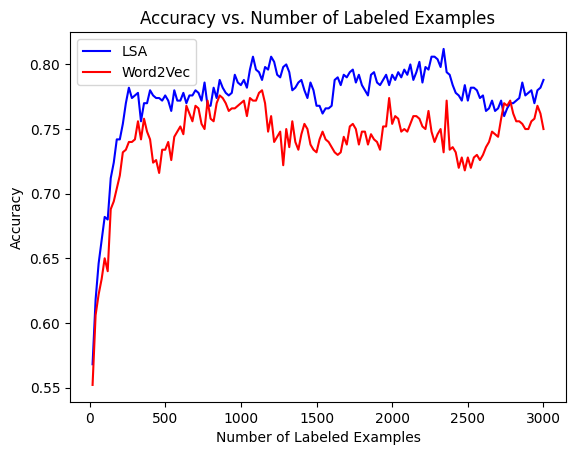

In [70]:
import matplotlib.pyplot as plt
axis = range(20, 3001, 20)
plt.plot(axis, lsa, 'b', label = 'LSA')
plt.plot(axis, word2vec, 'r', label = 'Word2Vec')
plt.xlabel('Number of Labeled Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Number of Labeled Examples')
plt.show()